# LLF_tidy_images - Extended Recruitment Experiment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from proglearn.forest import LifelongClassificationForest
from sklearn.model_selection import train_test_split

In [3]:
from matplotlib.ticker import ScalarFormatter

from proglearn.progressive_learner import ClassificationProgressiveLearner
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter
from proglearn.deciders import SimpleArgmaxAverage

## FTE/BTE Experiment

### Check Imports

In [2]:
dataset_name = "food_101_array_data_x_1"
load = np.load(dataset_name + '.npz')

print(load['arr_0'][0].shape)
print(len(load['arr_0']))

(32, 32, 3)
34000


In [3]:
dataset_name = "dtd_array_data_x"
load = np.load(dataset_name + '.npz')

print(load['arr_0'][0].shape)
print(len(load['arr_0']))

(32, 32, 3)
4800


In [4]:
dataset_name = '101_ObjectCategories'
load = np.load(dataset_name + '.npz')

print(load['imgs'][0].shape)
print(len(load['imgs']))
print(len(load['lbls']))

(32, 32, 3)
9144
9144


In [5]:
labels = pd.Index(load['lbls'])
labels.value_counts()

16    800
79    798
91    467
44    435
95    435
     ... 
39     34
71     34
74     33
98     32
96     31
Length: 102, dtype: int64

In [6]:
labels.value_counts()[labels.value_counts()>=50]

16    800
79    798
91    467
44    435
95    435
     ... 
69     52
8      51
33     51
42     50
68     50
Length: 68, dtype: int64

### Preprocess Data

In [4]:
data = []
labels = []

# import datasets that emily preprocessed
for set1 in ['101_ObjectCategories', 'CIFAR_10', 'CIFAR_100']:
    # load from npz
    load = np.load(set1 + '.npz')
    # reformat and append
    data.append(load['imgs'].reshape(len(load['imgs']), -1).astype(np.uint8))
    labels.append(load['lbls'].astype(np.uint16))

# import datasets that rahul preprocessed
food_101 = np.empty((0,32*32*3), np.uint8)
for set2 in ['food_101_array_data_x_1', 'food_101_array_data_x_2', 'food_101_array_data_x_3']:
    # load from npz
    load = np.load(set2 + '.npz')
    # reformat and append
    food_101 = np.vstack((food_101,load['arr_0'].reshape(len(load['arr_0']), -1).astype(np.uint8)))
data.append(food_101)
labels.append(np.concatenate([([i]*1000) for i in list(range(100))], axis=0).astype(np.uint16))
# load from npz
load = np.load('dtd_array_data_x.npz')
# reformat and append
data.append(load['arr_0'].reshape(len(load['arr_0']), -1).astype(np.uint8))
labels.append(np.concatenate([([i]*120) for i in list(range(40))], axis=0).astype(np.uint16))
labels

[array([  0,   0,   0, ..., 101, 101, 101], dtype=uint16),
 array([6, 9, 9, ..., 5, 1, 7], dtype=uint16),
 array([19, 29,  0, ..., 51, 42, 70], dtype=uint16),
 array([ 0,  0,  0, ..., 99, 99, 99], dtype=uint16),
 array([ 0,  0,  0, ..., 39, 39, 39], dtype=uint16)]

In [5]:
# modify labels
labels2 = []
for idx, lbl_set in enumerate(labels):
    if idx == 0:
        labels2.append(labels[idx])
    else:
        counter = 0
        for i in range(idx):
            counter += len(np.unique(labels[i]))
        labels2.append(labels[idx] + counter)
labels = labels2
labels

[array([  0,   0,   0, ..., 101, 101, 101], dtype=uint16),
 array([108, 111, 111, ..., 107, 103, 109], dtype=uint16),
 array([131, 141, 112, ..., 163, 154, 182], dtype=uint16),
 array([212, 212, 212, ..., 311, 311, 311], dtype=uint16),
 array([312, 312, 312, ..., 351, 351, 351], dtype=uint16)]

### FTE/BTE Experiment

In [5]:
##### MAIN HYPERPARAMS ##################
model = "uf"
num_tasks = 5
num_trees = 10
num_points_per_task = 500 #5000 # per dataset
reps = 5 #30
#########################################

#### Run Experiment

In [6]:
x_data = data
y_data = labels

In [7]:
# initialize list for storing results
accuracies_across_tasks = []

# format data
if model == 'dnn': # add dnn implementation in the future
    x = x_data
    y = y_data
elif model == 'uf':
    x = x_data #.reshape(len(x_data),-1)
    y = y_data

# get y values per task
ys_by_task = [np.unique(i) for i in labels]

# run experiment over all reps
for rep in range(reps):
    print('Starting rep', rep)
    
    train_x_task = []
    train_y_task = []
    test_x_task = []
    test_y_task = []
    
    # sample num_points_per_task from each dataset
    x_sample = []
    y_sample = []
    for dataset, label in zip(x, y):
        sample = np.random.choice(len(dataset), num_points_per_task)
        x_sample.append(dataset[sample])
        y_sample.append(label[sample])
    
    # initialize overall learner
    learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)

    # for each task
    for task in range(num_tasks):
        print('task', task)

        # get train/test data 
        tr_x, te_x, tr_y, te_y = train_test_split(x_sample[task], y_sample[task], test_size=0.2)
        train_x_task.append(tr_x)
        train_y_task.append(tr_y)
        test_x_task.append(te_x)
        test_y_task.append(te_y)
        
        # predict on single task (UF learner) - CHANGE TO UNCERTAINTYFOREST LATERS
        uf_learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)
        uf_learner.add_task(train_x_task[task], train_y_task[task])
        uf_predictions = uf_learner.predict(test_x_task[task], task_id=0)
        accuracies_across_tasks.append(np.mean(uf_predictions == test_y_task[task]))
        
        # feed to overall learner 
        learner.add_task(train_x_task[task], train_y_task[task])

        # evaluate for other tasks
        for other_task in range(num_tasks):

            if other_task > task:
                pass

            else:
                # predict on current task using other tasks
                prev_task_predictions = learner.predict(test_x_task[other_task], task_id=other_task)
                accuracies_across_tasks.append(np.mean(prev_task_predictions == test_y_task[other_task]))
        
# average results
accuracy_all_task = np.array(accuracies_across_tasks).reshape((reps, -1))
accuracy_all_task = np.mean(accuracy_all_task, axis = 0)

Starting rep 0
task 0
task 1
task 2
task 3
task 4
Starting rep 1
task 0
task 1
task 2
task 3
task 4
Starting rep 2
task 0
task 1
task 2
task 3
task 4
Starting rep 3
task 0
task 1
task 2
task 3
task 4
Starting rep 4
task 0
task 1
task 2
task 3
task 4


In [8]:
accuracy_all_task

array([0.33 , 0.336, 0.24 , 0.34 , 0.258, 0.052, 0.338, 0.28 , 0.06 ,
       0.018, 0.34 , 0.284, 0.054, 0.022, 0.102, 0.332, 0.258, 0.072,
       0.028, 0.13 ])

In [34]:
# accuracy
err = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err[i].append(1-accuracy_all_task[np.sum(list(range(1,j+2)))+i])

# backwards transfer efficiency
bte = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
        err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
        bte[i].append(err_up_to_taskt/err_all_seen)

# forwards transfer efficiency
fte = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
    err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
    fte[i].append(err_taskt_only/err_up_to_taskt)

# transfer efficiency
te = [[] for i in range(num_tasks)]
for i in range(num_tasks):
    for j in range(i, num_tasks):
        err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
        err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
        te[i].append(err_taskt_only/err_all_seen)

In [35]:
fte

[[1.0090361445783134],
 [1.0242587601078168],
 [1.0085106382978724],
 [1.0040899795501022],
 [1.0321839080459771]]

In [36]:
bte

[[1.0,
  1.006060606060606,
  1.0030211480362536,
  1.0060606060606059,
  0.9940119760479041],
 [1.0, 1.0305555555555557, 1.0363128491620113, 1.0],
 [1.0, 0.9936575052854123, 1.0129310344827585],
 [1.0, 1.0061728395061729],
 [1.0]]

In [37]:
te

[[1.0090361445783134,
  1.0151515151515151,
  1.012084592145015,
  1.015151515151515,
  1.0029940119760479],
 [1.0242587601078168,
  1.0555555555555556,
  1.0614525139664805,
  1.0242587601078168],
 [1.0085106382978724, 1.0021141649048626, 1.0215517241379308],
 [1.0040899795501022, 1.0102880658436215],
 [1.0321839080459771]]

In [38]:
err

[[0.6639999999999999, 0.6599999999999999, 0.662, 0.66, 0.6679999999999999],
 [0.742, 0.72, 0.716, 0.742],
 [0.94, 0.946, 0.928],
 [0.978, 0.972],
 [0.87]]

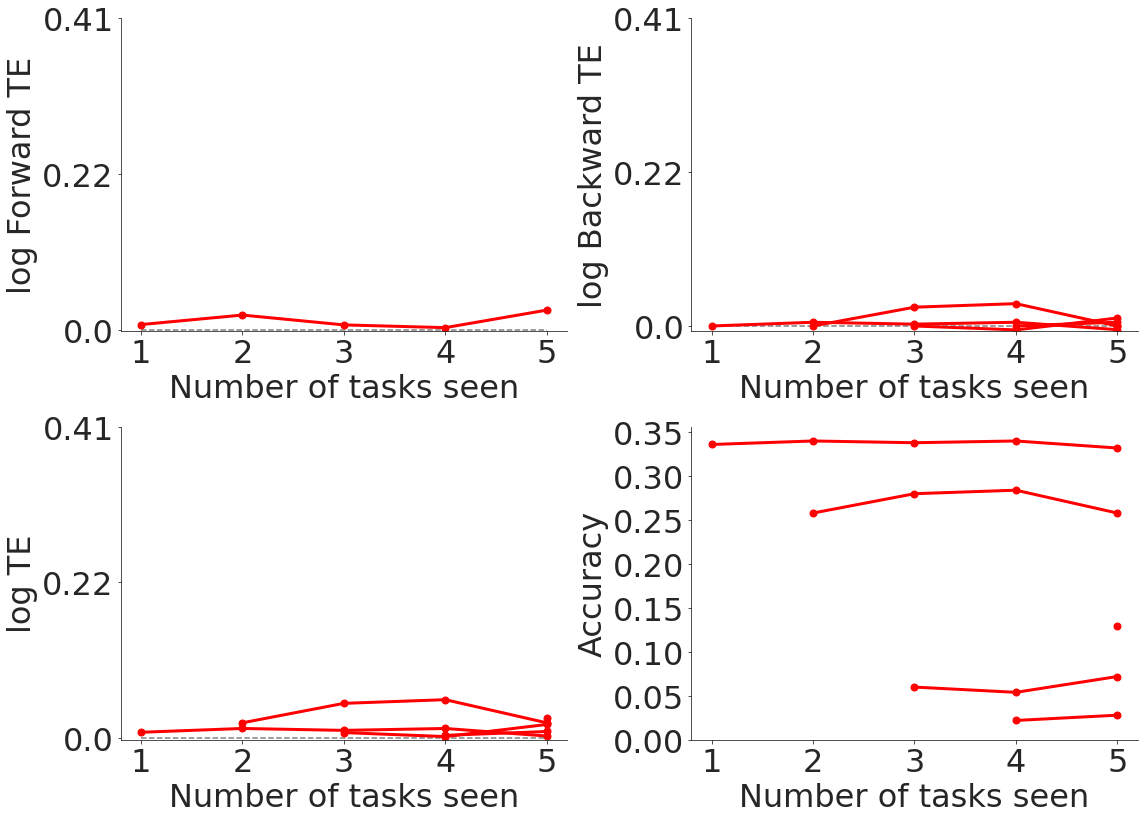

In [42]:
# set figure parameters and plot results 
sns.set_style('ticks')
clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
fontsize=32
ticksize=32

fig, ax = plt.subplots(2,2, figsize=(16,11.5))
sns.despine()
sns.color_palette("Set1")

ax[0][0].plot(np.arange(1,num_tasks+1), fte, c='red', marker='.', markersize=14, linewidth=3)
ax[0][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('log Forward TE', fontsize=fontsize)
ax[0][0].set_xticks(list(range(1, num_tasks+1)))
ax[0][0].set_yticks([1,1.25,1.5])
log_lbl = np.round(np.log([1,1.25,1.5]),2)
labels = [item.get_text() for item in ax[0][0].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[0][0].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(bte[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('log Backward TE', fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][1].set_xticks(list(range(1, num_tasks+1)))
ax[0][1].set_yticks([1,1.25,1.5])
log_lbl = np.round(np.log([1,1.25,1.5]),2)
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[0][1].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(te[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('log TE', fontsize=fontsize)
#ax[1][0].set_xticks(np.arange(1,10))
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[1][0].set_xticks(list(range(1, num_tasks+1)))
ax[1][0].set_yticks([1,1.25,1.5])
log_lbl = np.round(np.log([1,1.25,1.5]),2)
labels = [item.get_text() for item in ax[1][0].get_yticklabels()]
for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])
ax[1][0].set_yticklabels(labels)

for i in range(num_tasks):
    et = np.asarray(err[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][1].plot(ns, 1-et , c='red', marker='.', markersize=14, linewidth=3)

ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)
ax[1][1].set_xticks([1,2,3,4,5])
ax[1][1].set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])

#fig.suptitle("Transfer Efficiency Between MNIST and Fashion-MNIST", fontsize=36)
plt.tight_layout()

## Recruitment Experiment

In [6]:
x_data = data
y_data = labels

In [7]:
class PosteriorsByTreeLearner(ClassificationProgressiveLearner):
    """
    Variation on the progressive learner class ClassificationProgressiveLearner
    to allow for return of posterior probabilities by tree.
    """

    def predict_proba(self, X, task_id, transformer_ids=None):
        """
        Calls predict_proba_tree for the decider class. Works in conjunction with
        class PosteriorsByTree.
        """
        decider = self.task_id_to_decider[task_id]
        return self.task_id_to_decider[task_id].predict_proba_tree(
            X, transformer_ids=transformer_ids
        )

In [8]:
class PosteriorsByTree(SimpleArgmaxAverage):
    """Variation on the decider class SimpleArgmaxAverage to allow for return of
    posterior probabilities by tree.
    """

    def predict_proba_tree(self, X, transformer_ids=None):
        """
        Predicts posterior probabilities by tree.
        Returns array of dimension (num_transformers*len(transformer_ids))
        containing posterior probabilities.
        """
        vote_per_alltrees = []
        for transformer_id in (
            transformer_ids
            if transformer_ids is not None
            else self.transformer_id_to_voters_.keys()
        ):
            for bag_id in range(
                len(self.transformer_id_to_transformers_[transformer_id])
            ):
                transformer = self.transformer_id_to_transformers_[transformer_id][
                    bag_id
                ]
                X_transformed = transformer.transform(X)
                voter = self.transformer_id_to_voters_[transformer_id][bag_id]
                vote = voter.predict_proba(X_transformed)
                vote_per_alltrees.append(vote)
        return vote_per_alltrees

In [125]:
############################
### Main hyperparameters ###
############################
num_trees = 10
num_tasks = 5
reps = 1
estimation_set = 0.63
train_points_per_task = 4000
test_points_per_task = 400
last_task_sample = 10*np.array([10, 25, 50, 100, 200, 400])

In [123]:
x = data
y = labels

In [126]:
# def experiment_mnist(
#     x,
#     y,
#     num_trees,
#     num_tasks,
#     reps,
#     estimation_set,
#     train_points_per_task,
#     test_points_per_task,
#     last_task_sample,
# ):
#     """
#     Run the recruitment experiment.
#     Generalized for MNIST datasets and different task numbers.
#     """

# create matrices for storing values
hybrid = np.zeros(reps, dtype=float)
building = np.zeros(reps, dtype=float)
recruiting = np.zeros(reps, dtype=float)
uf = np.zeros(reps, dtype=float)
mean_accuracy_dict = {"building": [], "UF": [], "recruiting": [], "hybrid": []}
std_accuracy_dict = {"building": [], "UF": [], "recruiting": [], "hybrid": []}

# get y values and number labels per task
ys_by_task = [np.unique(i) for i in labels]
num_labels_by_task = [len(ys) for ys in ys_by_task]

# iterate over all sample sizes ns
for ns in last_task_sample:

    # size of estimation and validation sample sets
    estimation_sample_no = int(np.ceil(estimation_set * ns))
    validation_sample_no = ns - estimation_sample_no

    # repeat `rep` times
    for rep in range(reps):
        print("doing {} samples for {} th rep".format(ns,rep))
        
        ####### PREP DATA ##################################
        
        train_x_task = []
        train_y_task = []
        test_x_task = []
        test_y_task = []

        # sample [train+test]_points_per_task from each dataset
        for dataset, label in zip(x, y):
            sample = np.random.choice(len(dataset), train_points_per_task+test_points_per_task)

            # get train/test data 
            tr_x, te_x, tr_y, te_y = train_test_split(dataset[sample], label[sample], 
                                                      test_size=test_points_per_task/(train_points_per_task+test_points_per_task))
            train_x_task.append(tr_x)
            train_y_task.append(tr_y)
            test_x_task.append(te_x)
            test_y_task.append(te_y)

        ####################################################
        

        # initiate lifelong learner
        l2f = PosteriorsByTreeLearner(
            default_transformer_class=TreeClassificationTransformer,
            default_transformer_kwargs={},
            default_voter_class=TreeClassificationVoter,
            default_voter_kwargs={},
            default_decider_class=PosteriorsByTree,
            default_decider_kwargs={},
        )

        # train l2f on first tasks
        for task in range(num_tasks - 1):
            
            cur_X = train_x_task[task]
            cur_y = train_y_task[task]
            
            l2f.add_task(
                cur_X,
                cur_y,
                num_transformers=num_trees,
                transformer_kwargs={"kwargs":{"max_depth": 30}},
                voter_kwargs={"classes": np.unique(cur_y)},
                decider_kwargs={"classes": np.unique(cur_y)},
            )

        # train l2f on last task
        cur_X = train_x_task[num_tasks - 1][:estimation_sample_no]
        cur_y = train_y_task[num_tasks - 1][:estimation_sample_no]

        l2f.add_task(
            cur_X,
            cur_y,
            num_transformers=num_trees,
            transformer_kwargs={"kwargs":{"max_depth": 30}},
            voter_kwargs={"classes": np.unique(cur_y)},
            decider_kwargs={"classes": np.unique(cur_y)},
        )

        ## L2F validation ####################################
        # get posteriors for l2f on first 9 tasks
        # want posteriors_across_trees to have shape ((num_tasks-1)*num_trees, validation_sample_no, 10)
        posteriors_across_trees = l2f.predict_proba(
            train_x_task[num_tasks - 1][estimation_sample_no:],
            task_id=num_tasks - 1,
            transformer_ids=list(range(num_tasks - 1)),
        )
        # compare error in each tree and choose best 25/50 trees
        error_across_trees = np.zeros((num_tasks - 1) * num_trees)
        validation_target = train_y_task[num_tasks - 1][estimation_sample_no:]
        for tree in range(len(posteriors_across_trees)):
            res = np.argmax(
                posteriors_across_trees[tree], axis=1
            ) + sum(num_labels_by_task[:num_tasks-1])
            error_across_trees[tree] = 1 - np.mean(validation_target == res)
        best_50_tree = np.argsort(error_across_trees)[:50]
        best_25_tree = best_50_tree[:25]

        ## uf trees validation ###############################
        # get posteriors for l2f on only the 10th task
        posteriors_across_trees = l2f.predict_proba(
            train_x_task[num_tasks - 1][estimation_sample_no:],
            task_id=num_tasks - 1,
            transformer_ids=[num_tasks - 1],
        )
        # compare error in each tree and choose best 25 trees
        error_across_trees = np.zeros(num_trees)
        validation_target = train_y_task[num_tasks - 1][estimation_sample_no:]
        for tree in range(num_trees):
            res = np.argmax(
                posteriors_across_trees[tree], axis=1
            ) + sum(num_labels_by_task[:num_tasks-1])
            error_across_trees[tree] = 1 - np.mean(validation_target == res)
        best_25_uf_tree = np.argsort(error_across_trees)[:25]

        ## evaluation ########################################
        # train 10th tree under each scenario: building, recruiting, hybrid, UF
        # BUILDING
        building_res = l2f.predict(
            test_x_task[num_tasks - 1], task_id=num_tasks - 1
        )
        building[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == building_res)
        # UF
        uf_res = l2f.predict(
            test_x_task[num_tasks - 1],
            task_id=num_tasks - 1,
            transformer_ids=[num_tasks - 1],
        )
        uf[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == uf_res)
        # RECRUITING
        posteriors_across_trees = l2f.predict_proba(
            test_x_task[num_tasks - 1],
            task_id=num_tasks - 1,
            transformer_ids=list(range(num_tasks - 1)),
        )
        recruiting_posterior = np.mean(
            np.array(posteriors_across_trees)[best_50_tree], axis=0
        )
        res = np.argmax(recruiting_posterior, axis=1) + sum(num_labels_by_task[:num_tasks-1])
        recruiting[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == res)
        # HYBRID
        posteriors_across_trees_hybrid_uf = l2f.predict_proba(
            test_x_task[num_tasks - 1],
            task_id=num_tasks - 1,
            transformer_ids=[num_tasks - 1],
        )
        hybrid_posterior_all = np.concatenate(
            (
                np.array(posteriors_across_trees)[best_25_tree],
                np.array(posteriors_across_trees_hybrid_uf)[best_25_uf_tree],
            ),
            axis=0,
        )
        hybrid_posterior = np.mean(hybrid_posterior_all, axis=0)
        hybrid_res = np.argmax(hybrid_posterior, axis=1) + sum(num_labels_by_task[:num_tasks-1])
        hybrid[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == hybrid_res)

    # print statements
    print(np.mean(building))
    print(np.mean(uf))
    print(np.mean(recruiting))
    print(np.mean(hybrid))

    # calculate mean and stdev for each
    mean_accuracy_dict["building"].append(np.mean(building))
    std_accuracy_dict["building"].append(np.std(building, ddof=1))
    mean_accuracy_dict["UF"].append(np.mean(uf))
    std_accuracy_dict["UF"].append(np.std(uf, ddof=1))
    mean_accuracy_dict["recruiting"].append(np.mean(recruiting))
    std_accuracy_dict["recruiting"].append(np.std(recruiting, ddof=1))
    mean_accuracy_dict["hybrid"].append(np.mean(hybrid))
    std_accuracy_dict["hybrid"].append(np.std(hybrid, ddof=1))
    
#     return mean_accuracy_dict, std_accuracy_dict

doing 100 samples for 0 th rep
0.9425
0.9425
0.9775
0.9825
doing 250 samples for 0 th rep


/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.915
0.905
0.9625
0.96
doing 500 samples for 0 th rep


/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.87
0.88
0.86
0.8725
doing 1000 samples for 0 th rep


/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.8075
0.8575
0.8075
0.7975
doing 2000 samples for 0 th rep


/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.725
0.7375
0.7275
0.72
doing 4000 samples for 0 th rep


/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.56
0.585
0.5575
0.5575


/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/echang39/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Plot Results

In [127]:
mean_accuracy_dict

{'building': [0.9425, 0.915, 0.87, 0.8075, 0.725, 0.56],
 'UF': [0.9425, 0.905, 0.88, 0.8575, 0.7375, 0.585],
 'recruiting': [0.9775, 0.9625, 0.86, 0.8075, 0.7275, 0.5575],
 'hybrid': [0.9825, 0.96, 0.8725, 0.7975, 0.72, 0.5575]}

In [128]:
std_accuracy_dict

{'building': [nan, nan, nan, nan, nan, nan],
 'UF': [nan, nan, nan, nan, nan, nan],
 'recruiting': [nan, nan, nan, nan, nan, nan],
 'hybrid': [nan, nan, nan, nan, nan, nan]}

In [137]:
def recruitment_plot(mean_acc_dict, std_acc_dict, last_task_sample, num_tasks):
    """
    Plot the results from the recruitment experiment.
    """
    # determine colors and labels for figure
    colors = sns.color_palette("Set1", n_colors=len(mean_acc_dict))
    labels = ["L2F (building)", "UF (new)", "recruiting", "hybrid"]

    # plot and format figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for i, key in enumerate(mean_acc_dict):
        ax.plot(last_task_sample, mean_acc_dict[key], c=colors[i], label=labels[i])
        upper_bound = np.array(mean_acc_dict[key]) + 1.96 * np.array(std_acc_dict[key])
        lower_bound = np.array(mean_acc_dict[key]) - 1.96 * np.array(std_acc_dict[key])
        ax.fill_between(
            last_task_sample,
            upper_bound,
            lower_bound,
            where=upper_bound >= lower_bound,
            facecolor=colors[i],
            alpha=0.15,
            interpolate=False,
        )
    ax.set_title("Recruitment Across Datasets", fontsize=30)
    ax.set_ylabel("Generalization Error (Task %d)" % num_tasks, fontsize=28)
    ax.set_xlabel("Number of Task %d Samples" % num_tasks, fontsize=30)
    ax.tick_params(labelsize=28)
    ax.set_xscale("log")
    ax.set_xticks([100, 250, 500, 1000, 2000, 4000])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()
    ax.set_ylim(0.8, 1.0)
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.00])
    ax.legend(fontsize=12)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    plt.tight_layout()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal


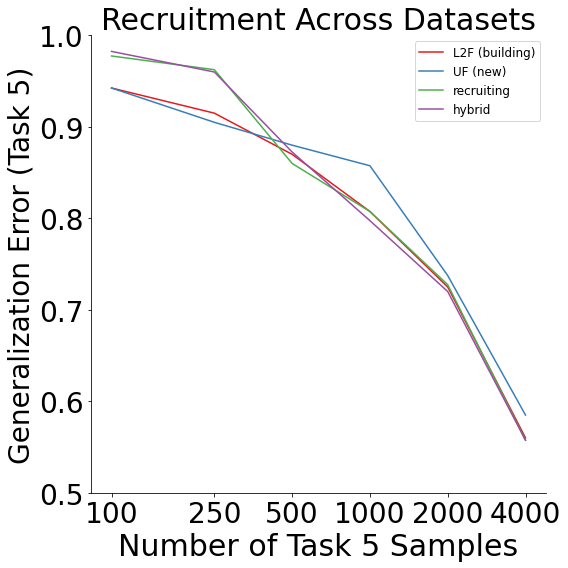

In [138]:
recruitment_plot(mean_accuracy_dict, std_accuracy_dict, last_task_sample, num_tasks)